In [1]:
%matplotlib inline 
from IPython.display import display
import os
import datetime
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

## Define parameters

In [2]:
station_coords = (-31.5667, -68.4167)

station_data_file = os.path.join("data", "san_juan_airport_data.csv")
era5_data_file = os.path.join("data", "era5-san-juan-airport-2018.nc")

low_temperature_threshold = 5 + 273.15

## Read San Juan Airport station data

In [3]:
station = pd.read_csv(station_data_file, index_col="time", parse_dates=True)
station.dropna(how="any", inplace=True)
station = station.to_xarray()
station

<xarray.Dataset>
Dimensions:     (time: 17206)
Coordinates:
  * time        (time) datetime64[ns] 2017-11-28T03:00:00 ... 2019-11-19T02:00:00
Data variables:
    temp        (time) float64 294.9 294.4 293.4 292.1 ... 300.9 300.1 298.9
    humidity    (time) float64 30.0 30.0 36.0 41.0 40.0 ... 25.0 27.0 29.0 31.0
    pressure    (time) float64 1.016e+05 1.016e+05 ... 1.012e+05 1.013e+05
    wind_dir    (time) float64 230.0 200.0 200.0 140.0 ... 200.0 200.0 200.0
    wind_speed  (time) float64 17.0 11.0 11.0 6.0 6.0 ... 19.0 11.0 13.0 15.0
    station     (time) object 'SAN JUAN AERO' ... 'SAN JUAN AERO'

## Read ERA-5 data for the San Juan Airport location

In [4]:
era5 = xr.open_dataset(era5_data_file)
era5

<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -68.5
  * latitude   (latitude) float32 -31.5
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-20 23:31:41 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [5]:
era5 = era5.sel(longitude=-68.5, latitude=-31.5)

/home/santi/.miniconda3/envs/camalot/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


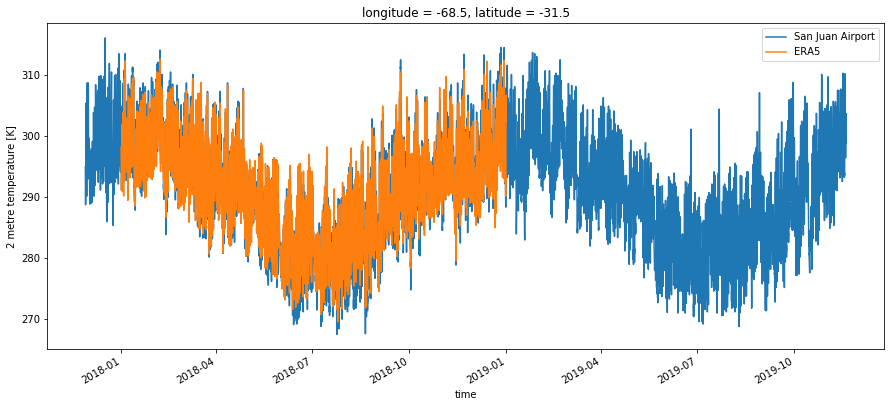

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
station.temp.plot(label="San Juan Airport")
era5.t2m.plot(label="ERA5")
plt.legend()
plt.show()

## Compute difference between ERA-5 and station

In [7]:
difference = era5.t2m - station.temp
difference

<xarray.DataArray (time: 8690)>
array([-2.91456299,  0.3479248 , -0.18961182, ..., -1.09454956,
       -4.3328125 , -3.9427063 ])
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
    longitude  float32 -68.5
    latitude   float32 -31.5

**Reduce station and ERA-5 datasets to the same time range as the difference**

In [8]:
station = station.sel(time=difference.time)
station

<xarray.Dataset>
Dimensions:     (time: 8690)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
    longitude   float32 -68.5
    latitude    float32 -31.5
Data variables:
    temp        (time) float64 301.0 297.6 297.1 296.9 ... 307.6 307.9 306.4
    humidity    (time) float64 40.0 59.0 59.0 62.0 55.0 ... 23.0 20.0 22.0 26.0
    pressure    (time) float64 1.006e+05 1.008e+05 ... 9.995e+04 9.993e+04
    wind_dir    (time) float64 180.0 180.0 160.0 160.0 ... 180.0 180.0 200.0
    wind_speed  (time) float64 43.0 30.0 26.0 26.0 28.0 ... 20.0 17.0 20.0 24.0
    station     (time) object 'SAN JUAN AERO' ... 'SAN JUAN AERO'

In [9]:
era5 = era5.sel(time=difference.time)
era5

<xarray.Dataset>
Dimensions:    (time: 8690)
Coordinates:
    longitude  float32 -68.5
    latitude   float32 -31.5
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m        (time) float32 ...
    sp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-20 23:31:41 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

## Plot histograms for the differences

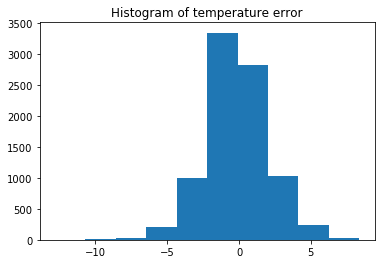

In [10]:
difference.plot.hist()
plt.title("Histogram of temperature error")
plt.show()

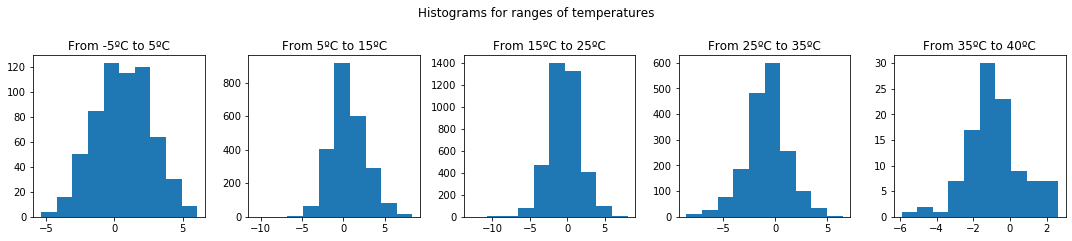

In [11]:
temp_ranges = np.arange(int(era5.t2m.min()) - 1, int(era5.t2m.max()) + 1 + 9, 10)
temp_ranges[0] = int(era5.t2m.min()) - 1
temp_ranges[-1] = int(era5.t2m.max()) + 1

n_axes = len(temp_ranges) - 1
fig, axes = plt.subplots(ncols=n_axes, nrows=1, figsize=(15, 3))


for ax, tmin, tmax in zip(axes, temp_ranges[:-1], temp_ranges[1:]):
    difference.loc[np.logical_and(era5.t2m > tmin, era5.t2m < tmax)].plot.hist(ax=ax)
    ax.set_title("From {}ºC to {}ºC".format(tmin - 273, tmax - 273))
plt.suptitle("Histograms for ranges of temperatures", y=1.1)
plt.tight_layout()
plt.show()

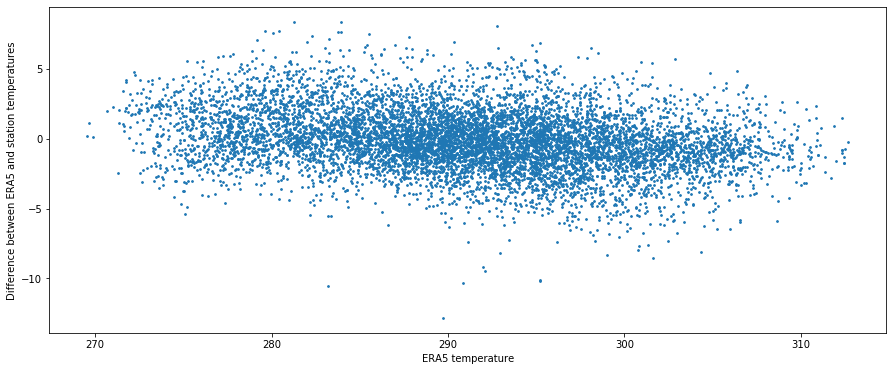

In [12]:
 fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(era5.t2m, difference, s=3)
plt.xlabel("ERA5 temperature")
plt.ylabel("Difference between ERA5 and station temperatures")
plt.show()

## How many true, missed and false alarms have occured?

In [13]:
# Compute the minimum temperature per day
station_min = station.temp.resample(time="1D").min()
era5_min = era5.t2m.resample(time="1D").min()

true_alarms = np.logical_and(station_min <= 273.15, era5_min <= 273.15)
missed_alarms = np.logical_and(station_min <= 273.15, era5_min > 273.15)
false_alarms = np.logical_and(station_min > 273.15, era5_min <= 273.15)

true_alarms = era5_min.time[true_alarms]
missed_alarms = era5_min.time[missed_alarms]
false_alarms = era5_min.time[false_alarms]

print(true_alarms)
print(missed_alarms)
print(false_alarms)

<xarray.DataArray 'time' (time: 15)>
array(['2018-06-12T00:00:00.000000000', '2018-06-15T00:00:00.000000000',
       '2018-06-16T00:00:00.000000000', '2018-06-17T00:00:00.000000000',
       '2018-07-09T00:00:00.000000000', '2018-07-10T00:00:00.000000000',
       '2018-07-12T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
       '2018-07-21T00:00:00.000000000', '2018-07-24T00:00:00.000000000',
       '2018-07-25T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-07-29T00:00:00.000000000', '2018-08-20T00:00:00.000000000',
       '2018-08-21T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2018-06-12 2018-06-15 ... 2018-08-21
    longitude  float32 -68.5
    latitude   float32 -31.5
<xarray.DataArray 'time' (time: 25)>
array(['2018-06-05T00:00:00.000000000', '2018-06-09T00:00:00.000000000',
       '2018-06-13T00:00:00.000000000', '2018-06-14T00:00:00.000000000',
       '2018-06-18T00:00:00.000000000', '2018-06-19T00:00:0

## Fit and apply temperature correction to ERA5 data

In [14]:
class TemperatureCorrection(object):
    """
    Apply temperature correction to forecast data
    
    The correction is computed by comparing historical station data
    with a global model data for the same time range.
    """
    
    def __init__(self):
        self.regression = None
    
    def fit(self, model_temperature, station_temperature):
        """
        Fit linear regression
        """
        difference = model_temperature - station_temperature
        self.regression = linregress(model_temperature, difference)
    
    def correct(self, temperature):
        """
        Apply correction to a set of temperatures
        """
        temp_corrected = temperature.copy()
        temp_corrected -= self.correction(temperature)
        return temp_corrected

    def correction(self, temperature):
        """
        Apply temperature correction function
        """
        correction = (
            self.regression.slope
            * temperature 
            + self.regression.intercept
        )
        return correction

Fit corrections to ERA5 data divinding it into low and high temperature ranges

In [15]:
low_temps = era5.t2m < low_temperature_threshold
high_temps = era5.t2m >= low_temperature_threshold

low_correction = TemperatureCorrection()
low_correction.fit(era5.t2m.loc[low_temps], station.temp.loc[low_temps])

high_correction = TemperatureCorrection()
high_correction.fit(era5.t2m.loc[high_temps], station.temp.loc[high_temps])

Plot differences vs ERA5 temperature and fitting functions

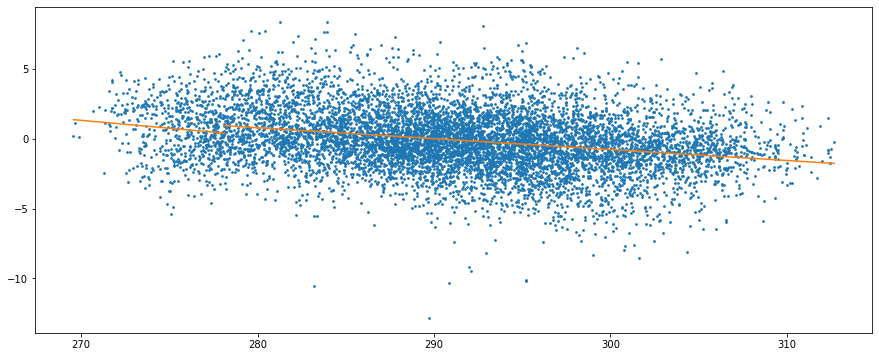

In [16]:
low_temps_bounds = np.array([era5.t2m.min(), low_temperature_threshold])
high_temps_bounds = np.array([low_temperature_threshold, era5.t2m.max()])

fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(era5.t2m, difference, s=3)
plt.plot(
    low_temps_bounds, low_correction.correction(low_temps_bounds), c="C1"
)
plt.plot(
    high_temps_bounds, high_correction.correction(high_temps_bounds), c="C1"
)
plt.show()

Apply correction to ERA5 data

In [17]:
era5_corrected = era5.t2m.copy()
era5_corrected.loc[low_temps] = low_correction.correct(era5.t2m.loc[low_temps])
era5_corrected.loc[high_temps] = high_correction.correct(era5.t2m.loc[high_temps])

difference_corrected = era5_corrected - station.temp

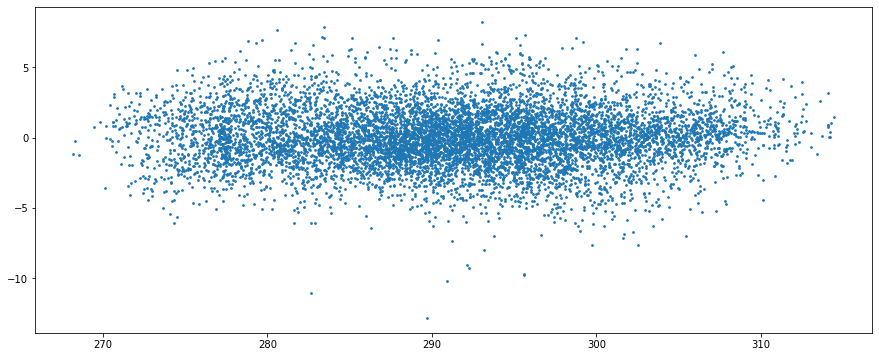

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(era5_corrected, difference_corrected, s=3)
plt.show()

## How many true, missed and false alarms would occur with the corrected temperatures?

In [19]:
station_min = station.temp.resample(time="1D").min()
era5_corrected_min = era5_corrected.resample(time="1D").min()

true_alarms = np.logical_and(station_min <= 273.15, era5_corrected_min <= 273.15)
missed_alarms = np.logical_and(station_min <= 273.15, era5_corrected_min > 273.15)
false_alarms = np.logical_and(station_min > 273.15, era5_corrected_min <= 273.15)

true_alarms = era5_min.time[true_alarms]
missed_alarms = era5_min.time[missed_alarms]
false_alarms = era5_min.time[false_alarms]

print(true_alarms)
print(missed_alarms)
print(false_alarms)

<xarray.DataArray 'time' (time: 24)>
array(['2018-06-05T00:00:00.000000000', '2018-06-12T00:00:00.000000000',
       '2018-06-13T00:00:00.000000000', '2018-06-14T00:00:00.000000000',
       '2018-06-15T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2018-06-17T00:00:00.000000000', '2018-06-18T00:00:00.000000000',
       '2018-06-22T00:00:00.000000000', '2018-06-26T00:00:00.000000000',
       '2018-07-09T00:00:00.000000000', '2018-07-10T00:00:00.000000000',
       '2018-07-11T00:00:00.000000000', '2018-07-12T00:00:00.000000000',
       '2018-07-20T00:00:00.000000000', '2018-07-21T00:00:00.000000000',
       '2018-07-24T00:00:00.000000000', '2018-07-25T00:00:00.000000000',
       '2018-07-26T00:00:00.000000000', '2018-07-29T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-08-04T00:00:00.000000000',
       '2018-08-20T00:00:00.000000000', '2018-08-21T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2018-0

## Plot histograms for the differences

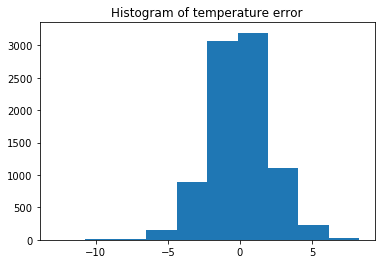

In [20]:
difference_corrected.plot.hist()
plt.title("Histogram of temperature error")
plt.show()

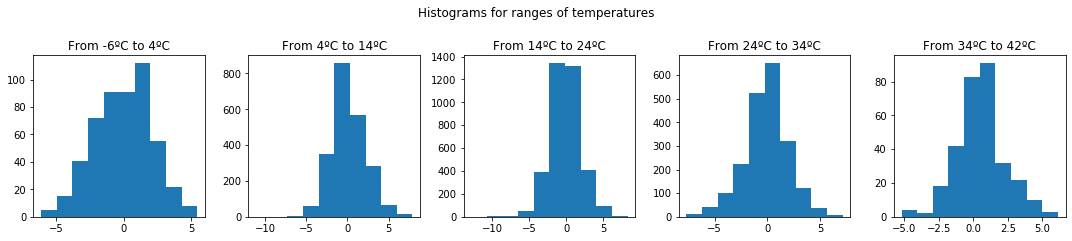

In [21]:
temp_ranges = np.arange(int(era5_corrected.min()) - 1, int(era5_corrected.max()) + 1 + 9, 10)
temp_ranges[0] = int(era5_corrected.min()) - 1
temp_ranges[-1] = int(era5_corrected.max()) + 1

n_axes = len(temp_ranges) - 1
fig, axes = plt.subplots(ncols=n_axes, nrows=1, figsize=(15, 3))


for ax, tmin, tmax in zip(axes, temp_ranges[:-1], temp_ranges[1:]):
    difference_corrected.loc[np.logical_and(era5_corrected > tmin, era5_corrected < tmax)].plot.hist(ax=ax)
    ax.set_title("From {}ºC to {}ºC".format(tmin - 273, tmax - 273))
plt.suptitle("Histograms for ranges of temperatures", y=1.1)
plt.tight_layout()
plt.show()